In [1]:
import sys
import os
import cv2
import math
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from datetime import datetime
from importlib import reload
from misc.utils import generate_generator, gen_imgPaths_and_labelPaths, monitor_mae, monitor_mse
from models import MCNNDS

# Settings
dataset = "B"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%matplotlib inline
np.random.seed(31415)

Using TensorFlow backend.


In [2]:
# # GPU check

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

## Data preprocessing

In [3]:
# Setting up paths

train_paths, train_labels, validation_paths, validation_labels, test_paths, test_labels = gen_imgPaths_and_labelPaths(dataset)

/datasets/crowd/ShanghaiTech/original/part_B/test_data/images/


In [4]:
# # Data import
# train_generator = generate_generator(train_paths, train_labels, batch_size=len(train_paths))
# validation_generator = generate_generator(validation_paths, validation_labels, batch_size=len(validation_paths))
# test_generator = generate_generator(test_paths, test_labels, batch_size=len(test_paths))
# train_img, train_labels = train_generator.__next__()
# print('Train data reading is done.')
# validation_img, validation_labels = validation_generator.__next__()
# print('Validation data reading is done.')
# test_img, test_labels = test_generator.__next__()
# print('Test data reading is done.')

In [5]:
# # Save preprocessed data

# if not os.path.exists('./data_preprocessed'):
#     os.makedirs('./data_preprocessed')
# np.save('./data_preprocessed/train_img.npy', train_img)
# np.save('./data_preprocessed/train_labels.npy', train_labels)
# np.save('./data_preprocessed/validation_img.npy', validation_img)
# np.save('./data_preprocessed/validation_labels.npy', validation_labels)
# np.save('./data_preprocessed/test_img.npy', test_img)
# np.save('./data_preprocessed/test_labels.npy', test_labels)

In [6]:
# Read data into memory

train_img, train_labels, validation_img, validation_labels, test_img, test_labels = (
    np.load('./data_preprocessed/train_img.npy'),
    np.load('./data_preprocessed/train_labels.npy'),
    np.load('./data_preprocessed/validation_img.npy'),
    np.load('./data_preprocessed/validation_labels.npy'),
    np.load('./data_preprocessed/test_img.npy'),
    np.load('./data_preprocessed/test_labels.npy')
)

## MCNN-DS 1:3

In [7]:
# Remove previous tensorboard data

if os.path.exists('./logs/train/'):
    shutil.rmtree('./logs/train/')
    
if os.path.exists('./logs/validation/'):
    shutil.rmtree('./logs/validation/')

In [8]:
# Model definition

reload(MCNNDS)

epochs = 200
batch_size = 20
model_name = 'mcnnds'
submodel_name = '1_3'
early_stopping_patience = 10

weights_val_path = f'./weights/{model_name}_{submodel_name}_{dataset}_val.hdf5'
weights_train_path = f'./weights/{model_name}_{submodel_name}_{dataset}_train.hdf5'
res_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{model_name}_{submodel_name}"

if os.path.exists(weights_val_path):
    os.remove(weights_val_path)

if os.path.exists(weights_train_path):
    os.remove(weights_train_path)

checkpointer_best_val = ModelCheckpoint(
    filepath=weights_val_path,
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

checkpointer_best_train = ModelCheckpoint(
    filepath=weights_train_path,
    monitor='loss', verbose=1, save_best_only=True, mode='min'
)

checkpointer_tensorboard = TensorBoard(log_dir='./logs')

early_stopping_monitor = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=early_stopping_patience,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = MCNNDS.MCNNDS()
model._get_distribution_strategy = lambda: None
adam = Adam()
model.compile(loss='mean_squared_error', optimizer=adam,
              metrics=[monitor_mae, monitor_mse])

history = model.fit(
    x=train_img, y=train_labels, batch_size=batch_size, epochs=epochs,
    validation_data=(validation_img, validation_labels),
    callbacks=[checkpointer_best_val,
               checkpointer_best_train, checkpointer_tensorboard, early_stopping_monitor]
)

Train on 3249 samples, validate on 351 samples
Epoch 1/200
3249/3249 [==============================] - 24s 7ms/step - loss: 2.6858e-04 - monitor_mae: 310.6603 - monitor_mse: 16.4456 - val_loss: 1.3388e-04 - val_monitor_mae: 195.5586 - val_monitor_mse: 8.0199

Epoch 00001: val_loss improved from inf to 0.00013, saving model to ./weights/mcnnds_1_3_B_val.hdf5

Epoch 00001: loss improved from inf to 0.00027, saving model to ./weights/mcnnds_1_3_B_train.hdf5
Epoch 2/200
3249/3249 [==============================] - 21s 6ms/step - loss: 2.0766e-04 - monitor_mae: 218.2401 - monitor_mse: 12.7157 - val_loss: 1.3793e-04 - val_monitor_mae: 253.1850 - val_monitor_mse: 8.2627

Epoch 00002: val_loss did not improve from 0.00013

Epoch 00002: loss improved from 0.00027 to 0.00021, saving model to ./weights/mcnnds_1_3_B_train.hdf5
Epoch 3/200
3249/3249 [==============================] - 21s 6ms/step - loss: 2.0521e-04 - monitor_mae: 212.7516 - monitor_mse: 12.5653 - val_loss: 1.3569e-04 - val_monitor

2020-10-21_01-07-55_mcnnds_1_3


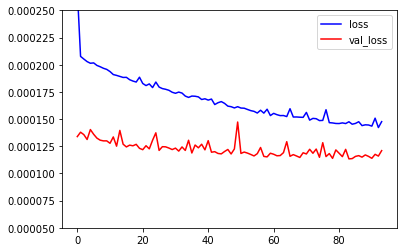

In [9]:
# Training history

val_loss, loss = history.history['val_loss'], history.history['loss']

plt.plot(loss, 'b')
plt.gca().set_ylim([0.00005, 0.00025])
plt.plot(val_loss, 'r')
plt.gca().set_ylim([0.00005, 0.00025])
plt.legend(['loss', 'val_loss'])

plt.savefig(os.path.join('results', f'{res_name}.png'))
pd.DataFrame({'loss': loss, 'val_loss': val_loss}).to_csv(
    os.path.join('results', f'{res_name}_train.csv'), index=False)

print(res_name)

In [10]:
# Model test

model = load_model(weights_val_path, custom_objects={
                   'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

ae = []
se = []
num_test = len(test_paths)
for i in range(test_img.shape[0])[:num_test]:
    inputs = np.reshape(test_img[i], [1, *test_img[i].shape[:2], 1])
    outputs = np.squeeze(model.predict(inputs))
    density_map = np.squeeze(test_labels[i])
    count_label = np.sum(density_map)
    count_prediction = np.sum(outputs)
    ae.append(abs(count_label - count_prediction))
    se.append((count_label - count_prediction) ** 2)

mae = np.mean(ae)
rmse = np.sqrt(np.mean(se))

pd.DataFrame({'MAE': [mae], 'RMSE': [rmse]}).to_csv(
    os.path.join('results', f'{res_name}_test.csv'), index=False)

print(res_name)
print(f'MAE: {mae}, RMSE: {rmse}')

2020-10-21_01-07-55_mcnnds_1_3
MAE: 47.4573802035066, RMSE: 75.45259422217819


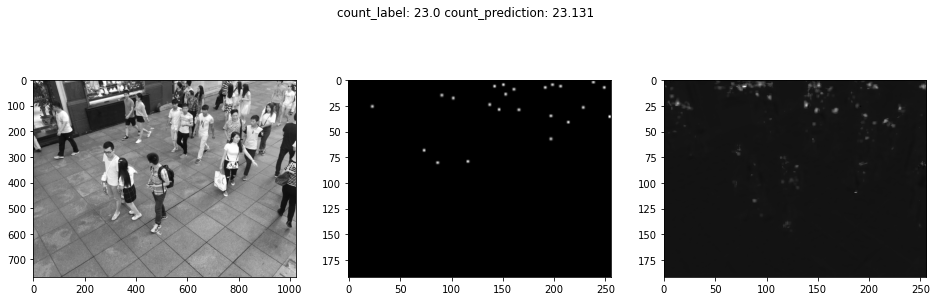

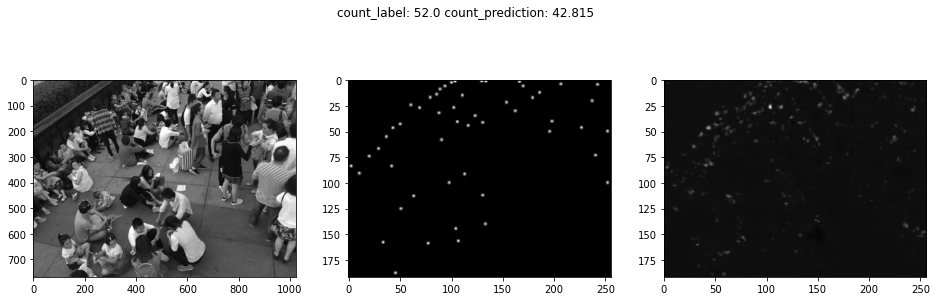

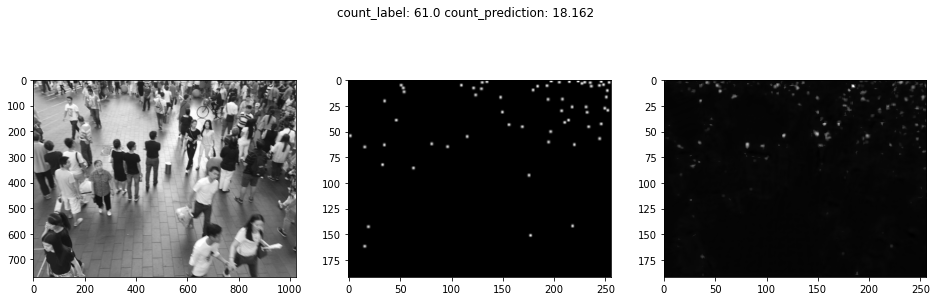

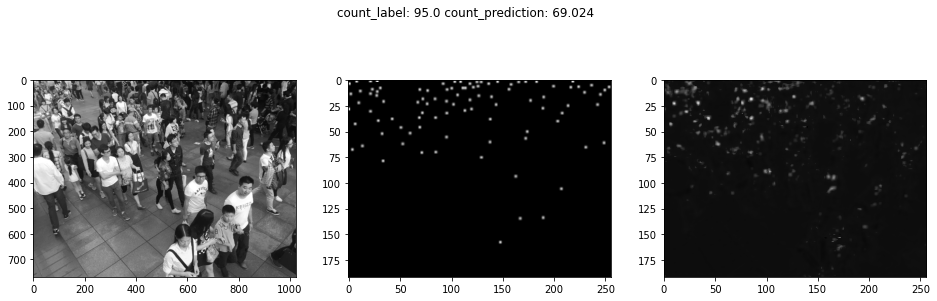

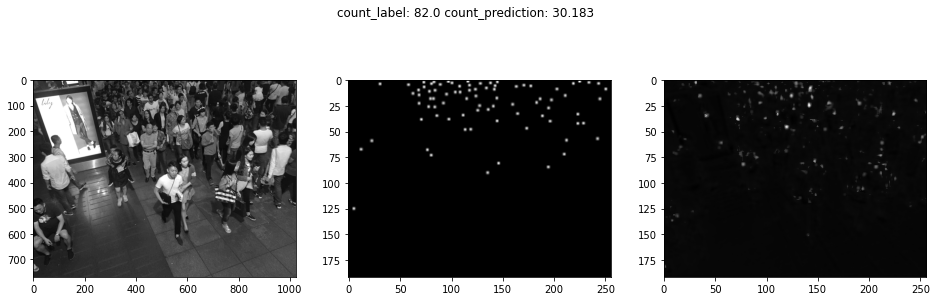

mae: 25.989363479614248 mse: 1055.842643082174


In [11]:
# Results presentation
ae = []
se = []
num_test = 5
for i in range(test_img.shape[0])[:num_test]:
    inputs = np.reshape(test_img[i], [1, *test_img[i].shape[:2], 1])
    outputs = np.squeeze(model.predict(inputs))
    density_map = np.squeeze(test_labels[i])
    count_label = np.sum(density_map)
    count_prediction = np.sum(outputs)
    fg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
    plt.suptitle(' '.join([
        'count_label:', str(round(count_label, 3)),
        'count_prediction:', str(round(count_prediction, 3))
    ]))
    ax0.imshow(np.squeeze(inputs), cmap='gray')
    ax1.imshow(density_map * (255 / (np.max(density_map) - np.min(density_map))), cmap='gray')
    ax2.imshow(outputs * (255 / (np.max(outputs) - np.min(outputs))), cmap='gray')
    plt.show()
    ae.append(abs(count_label - count_prediction))
    se.append((count_label - count_prediction) ** 2)
mae = np.mean(ae)
mse = np.mean(se)
print('mae:', mae, 'mse:', mse)

In [12]:
# Model profile
# ref: https://stackoverflow.com/questions/49525776/how-to-calculate-a-mobilenet-flops-in-keras

import tensorflow as tf
import keras

def get_flops(path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = load_model(path, custom_objects={'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

            """"
            We can check whether calculated FLOPS are the same as reported in MobileNet paper
            
            In MobileNet paper:
            MultAdds = 569,000,000
            FLOPS ~= 2*MultAdds = 1,138,000,000
            
            In our calculations
            FLOPS = 1,172,813,001
            
            So approx. equal. Should be ok.
            """
            # model = keras.applications.mobilenet.MobileNet(alpha=1, weights=None, input_tensor=tf.compat.v1.placeholder('float32', shape=(1, 224, 224, 3)))

            run_meta = tf.compat.v1.RunMetadata()
            
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)
            
    tf.compat.v1.reset_default_graph()

    return flops.total_float_ops

FLOPS = get_flops(weights_val_path)
print(f'FLOPS: {FLOPS:,}')
print(f'Mult-Adds: {int(FLOPS/2):,}')
print(f'Trainsable params: {model.count_params():,}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 198,425
Mult-Adds: 99,212
Trainsable params: 16,565


## MCNN-DS 1:1

In [13]:
# Remove previous tensorboard data

if os.path.exists('./logs/train/'):
    shutil.rmtree('./logs/train/')
    
if os.path.exists('./logs/validation/'):
    shutil.rmtree('./logs/validation/')

In [14]:
# Model definition

reload(MCNNDS)

epochs = 200
batch_size = 20
model_name = 'mcnnds'
submodel_name = '1_1'
early_stopping_patience = 10

weights_val_path = f'./weights/{model_name}_{submodel_name}_{dataset}_val.hdf5'
weights_train_path = f'./weights/{model_name}_{submodel_name}_{dataset}_train.hdf5'
res_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{model_name}_{submodel_name}"

if os.path.exists(weights_val_path):
    os.remove(weights_val_path)

if os.path.exists(weights_train_path):
    os.remove(weights_train_path)

checkpointer_best_val = ModelCheckpoint(
    filepath=weights_val_path,
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

checkpointer_best_train = ModelCheckpoint(
    filepath=weights_train_path,
    monitor='loss', verbose=1, save_best_only=True, mode='min'
)

checkpointer_tensorboard = TensorBoard(log_dir='./logs')

early_stopping_monitor = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=early_stopping_patience,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model = MCNNDS.MCNNDS_1_to_1()
model._get_distribution_strategy = lambda: None
adam = Adam()
model.compile(loss='mean_squared_error', optimizer=adam,
              metrics=[monitor_mae, monitor_mse])

history = model.fit(
    x=train_img, y=train_labels, batch_size=batch_size, epochs=epochs,
    validation_data=(validation_img, validation_labels),
    callbacks=[checkpointer_best_val,
               checkpointer_best_train, checkpointer_tensorboard, early_stopping_monitor]
)

Train on 3249 samples, validate on 351 samples
Epoch 1/200
3249/3249 [==============================] - 22s 7ms/step - loss: 2.8148e-04 - monitor_mae: 375.5856 - monitor_mse: 17.2356 - val_loss: 1.3527e-04 - val_monitor_mae: 196.1728 - val_monitor_mse: 8.1032

Epoch 00001: val_loss improved from inf to 0.00014, saving model to ./weights/mcnnds_1_1_B_val.hdf5

Epoch 00001: loss improved from inf to 0.00028, saving model to ./weights/mcnnds_1_1_B_train.hdf5
Epoch 2/200
3249/3249 [==============================] - 20s 6ms/step - loss: 2.0853e-04 - monitor_mae: 240.1765 - monitor_mse: 12.7688 - val_loss: 1.3618e-04 - val_monitor_mae: 219.1162 - val_monitor_mse: 8.1577

Epoch 00002: val_loss did not improve from 0.00014

Epoch 00002: loss improved from 0.00028 to 0.00021, saving model to ./weights/mcnnds_1_1_B_train.hdf5
Epoch 3/200
3249/3249 [==============================] - 20s 6ms/step - loss: 2.0553e-04 - monitor_mae: 221.0894 - monitor_mse: 12.5851 - val_loss: 1.3246e-04 - val_monitor

2020-10-21_01-41-38_mcnnds_1_1


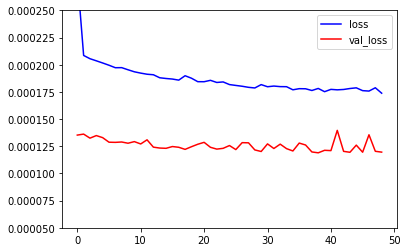

In [15]:
# Training history

val_loss, loss = history.history['val_loss'], history.history['loss']

plt.plot(loss, 'b')
plt.gca().set_ylim([0.00005, 0.00025])
plt.plot(val_loss, 'r')
plt.gca().set_ylim([0.00005, 0.00025])
plt.legend(['loss', 'val_loss'])

plt.savefig(os.path.join('results', f'{res_name}.png'))
pd.DataFrame({'loss': loss, 'val_loss': val_loss}).to_csv(
    os.path.join('results', f'{res_name}_train.csv'), index=False)

print(res_name)

In [16]:
# Model test

model = load_model(weights_val_path, custom_objects={
                   'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

ae = []
se = []
num_test = len(test_paths)
for i in range(test_img.shape[0])[:num_test]:
    inputs = np.reshape(test_img[i], [1, *test_img[i].shape[:2], 1])
    outputs = np.squeeze(model.predict(inputs))
    density_map = np.squeeze(test_labels[i])
    count_label = np.sum(density_map)
    count_prediction = np.sum(outputs)
    ae.append(abs(count_label - count_prediction))
    se.append((count_label - count_prediction) ** 2)

mae = np.mean(ae)
rmse = np.sqrt(np.mean(se))

pd.DataFrame({'MAE': [mae], 'RMSE': [rmse]}).to_csv(
    os.path.join('results', f'{res_name}_test.csv'), index=False)

print(res_name)
print(f'MAE: {mae}, RMSE: {rmse}')

2020-10-21_01-41-38_mcnnds_1_1
MAE: 44.76386472243296, RMSE: 72.28385462813719


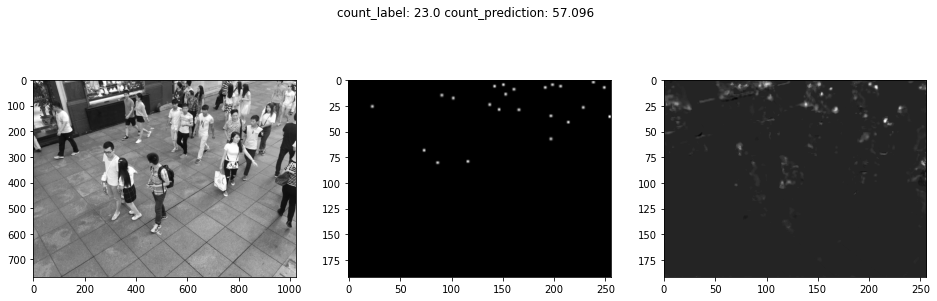

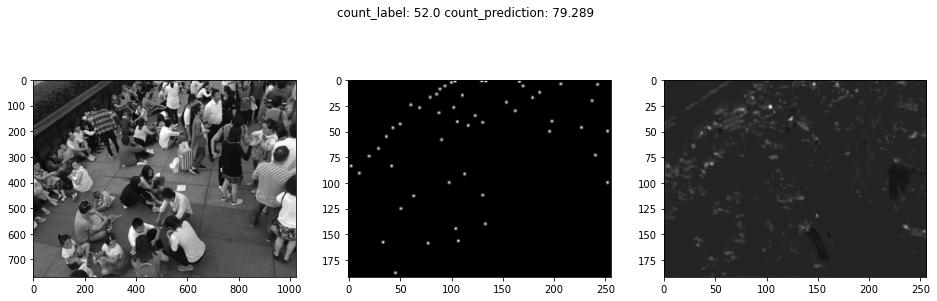

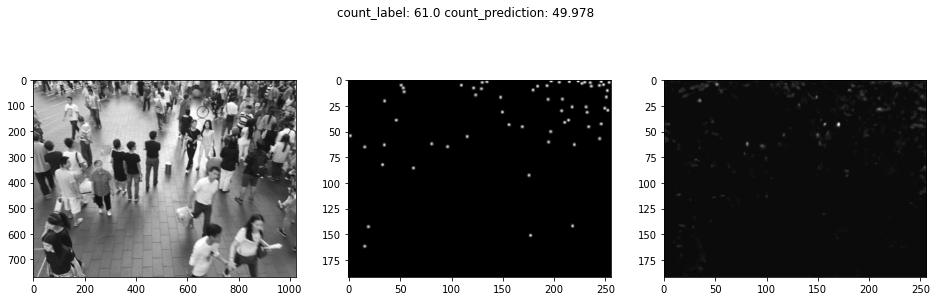

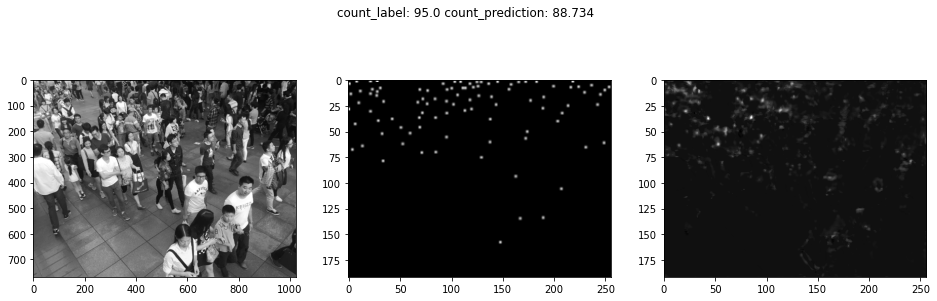

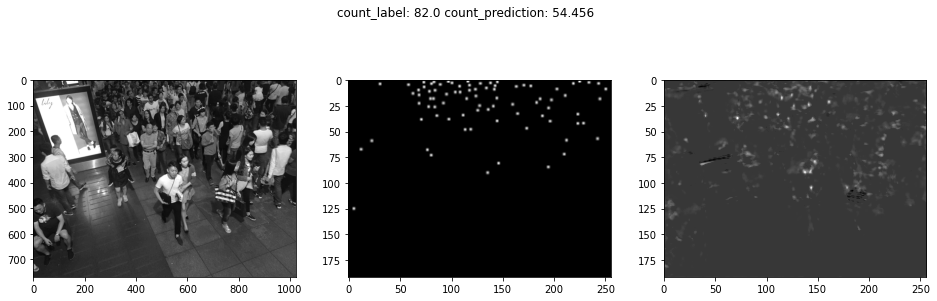

mae: 21.24347381591796 mse: 565.3312583251969


In [17]:
# Results presentation
ae = []
se = []
num_test = 5
for i in range(test_img.shape[0])[:num_test]:
    inputs = np.reshape(test_img[i], [1, *test_img[i].shape[:2], 1])
    outputs = np.squeeze(model.predict(inputs))
    density_map = np.squeeze(test_labels[i])
    count_label = np.sum(density_map)
    count_prediction = np.sum(outputs)
    fg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
    plt.suptitle(' '.join([
        'count_label:', str(round(count_label, 3)),
        'count_prediction:', str(round(count_prediction, 3))
    ]))
    ax0.imshow(np.squeeze(inputs), cmap='gray')
    ax1.imshow(density_map * (255 / (np.max(density_map) - np.min(density_map))), cmap='gray')
    ax2.imshow(outputs * (255 / (np.max(outputs) - np.min(outputs))), cmap='gray')
    plt.show()
    ae.append(abs(count_label - count_prediction))
    se.append((count_label - count_prediction) ** 2)
mae = np.mean(ae)
mse = np.mean(se)
print('mae:', mae, 'mse:', mse)

In [18]:
# Model profile
# ref: https://stackoverflow.com/questions/49525776/how-to-calculate-a-mobilenet-flops-in-keras

import tensorflow as tf
import keras

def get_flops(path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()

    with graph.as_default():
        with session.as_default():
            model = load_model(path, custom_objects={'monitor_mae': monitor_mae, 'monitor_mse': monitor_mse})

            """"
            We can check whether calculated FLOPS are the same as reported in MobileNet paper
            
            In MobileNet paper:
            MultAdds = 569,000,000
            FLOPS ~= 2*MultAdds = 1,138,000,000
            
            In our calculations
            FLOPS = 1,172,813,001
            
            So approx. equal. Should be ok.
            """
            # model = keras.applications.mobilenet.MobileNet(alpha=1, weights=None, input_tensor=tf.compat.v1.placeholder('float32', shape=(1, 224, 224, 3)))

            run_meta = tf.compat.v1.RunMetadata()
            
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)
            
    tf.compat.v1.reset_default_graph()

    return flops.total_float_ops

FLOPS = get_flops(weights_val_path)
print(f'FLOPS: {FLOPS:,}')
print(f'Mult-Adds: {int(FLOPS/2):,}')
print(f'Trainsable params: {model.count_params():,}')

FLOPS: 449,691
Mult-Adds: 224,845
Trainsable params: 37,504
